# Defense Wins Championships

It has been said that defense wins championships. Well, more precisely, the saying goes, "Offense wins games, defense wins championships." So I want to take a look at how offenses and defenses affect the chances of a team winning a given game. I will take a look the past 10 seasons of NFL games as the basis for my study. The regular season games will be used to build two models: offensive and defensive. Then I will test the models with the playoff data from the same 10 seasons to see which model is more accurate which will tell us whether defense truly is what wins championships.

### Hypothesis

Having a good offense is effective in winning regular season games, but in order to win championships, rather, playoff games leading to and including the championship game, defense will be what makes the difference.

### Method

I will gather offensive and defensive stats from the past 10 NFL seasons. They will be divided into regular season and postseason(playoff) games. The regular season games will be the dataset on which I will be training the models and the postseason data will be used to test the models. Each NFL season has 256 games (16 games/week x 16 weeks/season) for a total of 2560 games. For the purposes of this exercise, I will randomly pick 1000 games since the method of gathering each game data is labor intensive. In the postseason, 12 teams qualify and play a total of 11 games(4-wild card, 4-divisional, 2-conference, and the Super Bowl). That equates to 110 postseason games which would be roughly 10% of the size of the training dataset. Then I will compare the offensive model prediction accuracy with that of the defensive model to prove that defense is what makes a championship winning team.

### Data

The method which I will be gathering the data will be brute-force which is why it will be labor-intensive. I will be using the website www.pro-football-reference.com to convert the game stats to csv by copying the offense and defense game data on to a spreadsheet and then exporting it as a .csv file.

In [64]:
# Let's load the necessary packages and the data
import numpy as np
import pandas as pd
import pandas_profiling
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import time

In [69]:
# import data
col_names = ['win', 'venue', 'score', 'opp_score', 'completions', 'pass_att', 'pass_yds', 'pass_tds',
              'interceptions', 'sacks', 'yds_lost', 'yds_per_pass_att', 'comp_%', 'qb_rtg',
              'rush_att', 'rush_yds', 'yds_per_rush_att', 'rush_tds', 'fgs_made', 'fg_att',
              'x_pts_made', 'x_pt_att', 'punts', 'punt_yds', '3_down_conv', '3_down_att', 
              '4_down_conv', '4_down_att', 'time_of_poss']

offense = pd.read_csv('../../../Data/offense.csv', header=None, names=col_names)
offense.head(5)

,win,venue,score,opp_score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
0,L,NaN,16,20,26,44,259,1,2,3,...,3,1,1,6,328,4,14,0,1,28:23
1,W,@,31,17,27,32,265,2,0,0,...,2,4,4,3,139,2,9,1,1,31:21
2,L,NaN,21,34,27,46,226,2,5,2,...,0,3,3,4,210,4,10,1,2,27:02
3,W,@,41,21,22,33,256,5,1,1,...,2,5,5,4,166,8,14,0,0,33:16
4,W,NaN,31,20,29,38,340,2,0,0,...,1,4,4,7,364,2,12,1,2,31:30


In [70]:
defense = pd.read_csv('../../../Data/defense.csv', header=None, names=col_names)
defense.head(5)

,win,venue,score,opp_score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
0,L,@,23,35,29,41,285,4,1,1,...,1,2,2,5,189,8,16,0,1,33:20
1,W,@,16,13,20,37,190,0,1,4,...,2,1,1,7,303,8,18,0,0,33:09
2,L,NaN,17,28,13,18,174,2,0,1,...,0,4,4,7,311,2,9,0,0,23:45
3,W,NaN,18,15,24,49,210,0,1,3,...,5,0,0,7,351,5,19,1,1,33:13
4,L,@,7,34,21,30,297,4,1,1,...,2,4,4,3,129,9,14,0,0,35:47


Let's fix the 'win' and 'venue' columns.

In [71]:
# first change 'win' column values from string to number type
offense['win'] = np.where(offense['win'] == 'W', 1, 0)
defense['win'] = np.where(defense['win'] == 'W', 1, 0)

# change venue to more descriptive value
offense['venue'] = np.where(offense['venue'] == '@', 'away', 'home')
defense['venue'] = np.where(defense['venue'] == '@', 'away', 'home')

display(offense.head(5))
display(defense.head(5))

,win,venue,score,opp_score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
0,0,home,16,20,26,44,259,1,2,3,...,3,1,1,6,328,4,14,0,1,28:23
1,1,away,31,17,27,32,265,2,0,0,...,2,4,4,3,139,2,9,1,1,31:21
2,0,home,21,34,27,46,226,2,5,2,...,0,3,3,4,210,4,10,1,2,27:02
3,1,away,41,21,22,33,256,5,1,1,...,2,5,5,4,166,8,14,0,0,33:16
4,1,home,31,20,29,38,340,2,0,0,...,1,4,4,7,364,2,12,1,2,31:30


,win,venue,score,opp_score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
0,0,away,23,35,29,41,285,4,1,1,...,1,2,2,5,189,8,16,0,1,33:20
1,1,away,16,13,20,37,190,0,1,4,...,2,1,1,7,303,8,18,0,0,33:09
2,0,home,17,28,13,18,174,2,0,1,...,0,4,4,7,311,2,9,0,0,23:45
3,1,home,18,15,24,49,210,0,1,3,...,5,0,0,7,351,5,19,1,1,33:13
4,0,away,7,34,21,30,297,4,1,1,...,2,4,4,3,129,9,14,0,0,35:47


In [72]:
# Let's gather some stats on the stats
pandas_profiling.ProfileReport(offense)

Number of variables,29
Number of observations,1000
Total Missing (%),0.0%
Total size in memory,226.6 KiB
Average record size in memory,232.1 B
Numeric,23
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,3


In [73]:
pandas_profiling.ProfileReport(defense)

Number of variables,29
Number of observations,1000
Total Missing (%),0.0%
Total size in memory,226.6 KiB
Average record size in memory,232.1 B
Numeric,23
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,3


For both offense and defense data it's good to see that the venue and win column values are evenly distributed between two possibilities. On a cursory glance at least it looks like we have a random sample of games from the past 10 seasons. But let's visualize our data to examine it deeper.

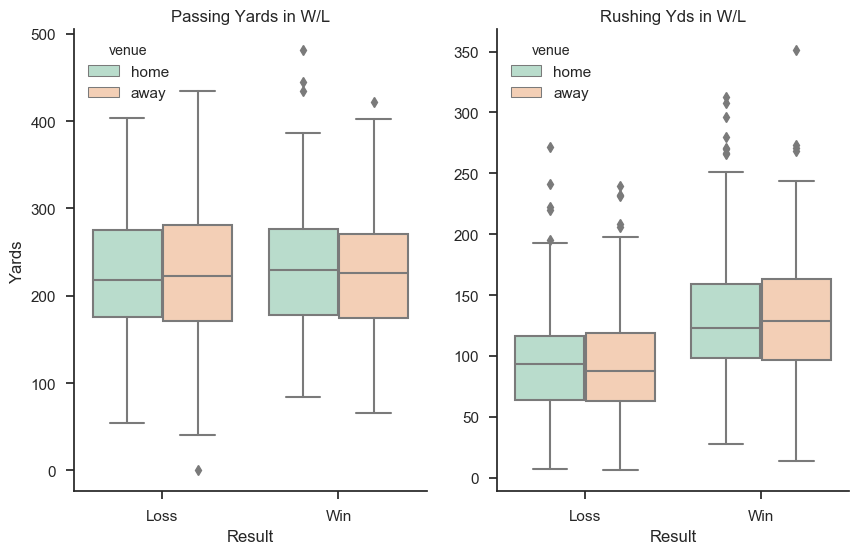

In [112]:
f, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.set(style='ticks', palette='Pastel2')
sns.despine()

x = 'win'
hue = 'venue'

ax1 = axes[0]
sns.boxplot(x=x, y='pass_yds', hue=hue, data=offense, ax=ax1)
ax1.set_title('Passing Yards in W/L')
ax1.set_ylabel('Yards')
ax1.set_xlabel('Result')
ax1.set_xticklabels(['Loss', 'Win'])

ax2 = axes[1]
sns.boxplot(x=x, y='rush_yds', hue=hue, data=offense, ax=ax2)
ax2.set_title('Rushing Yds in W/L')
ax2.set_ylabel('')
ax2.set_xlabel('Result')
ax2.set_xticklabels(['Loss', 'Win'])

plt.show()

0 passing yards? That seem